In [20]:
#
# In this notebook we examine the roles of storm oranization (size) and storm localization
#
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import binned_statistic, binned_statistic_2d, pearsonr, linregress
from src.regions import *
from src.pf_stats import *
from src.plotting import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Figure 2: Effects of localization

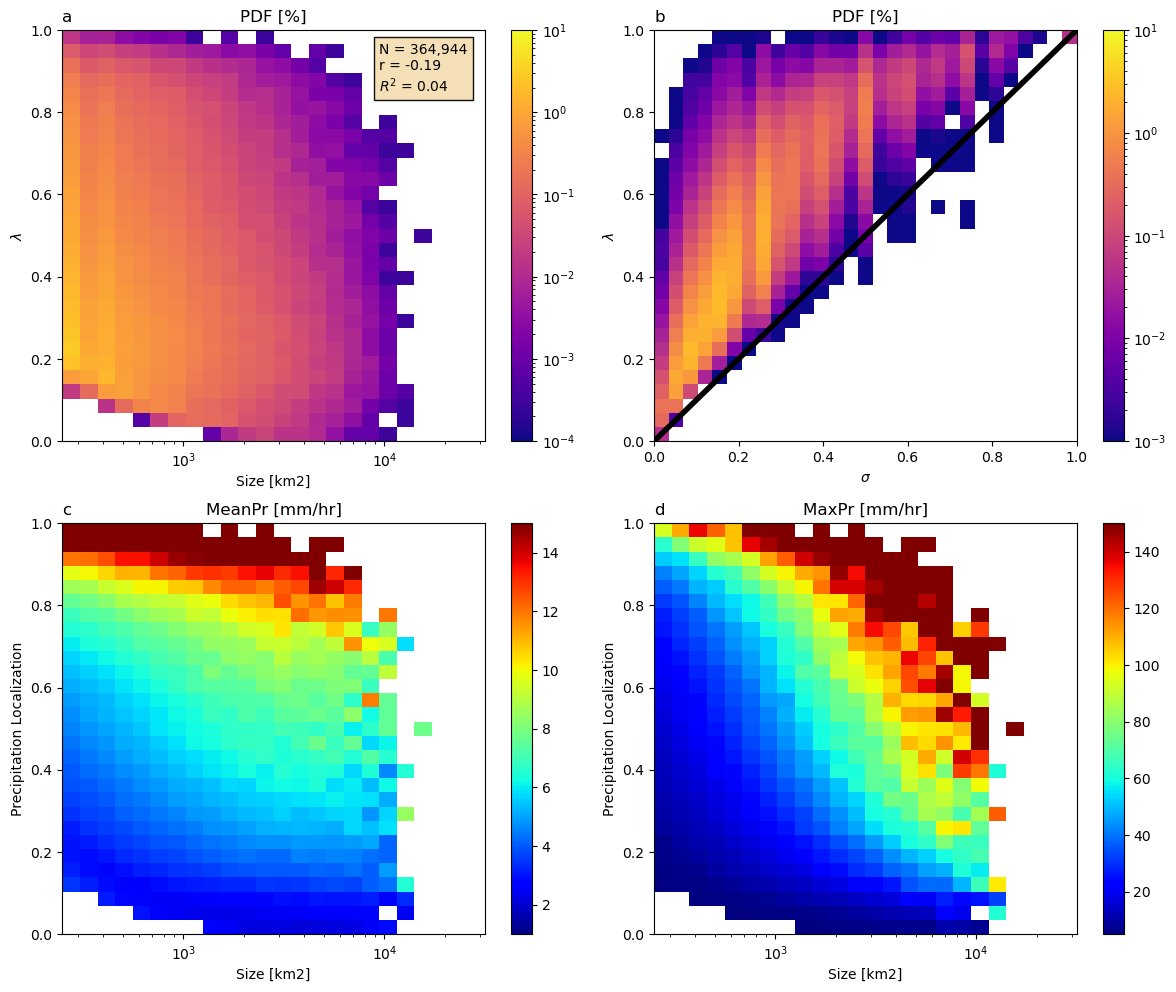

In [28]:
MAXPR_THRESH = 5

#
# Data is loaded.
#
regions = [
    cio_region(), 
    wmp_region(),
]

df = pd.concat(
    [load_pf_stats(r, maxpr_min=MAXPR_THRESH) for r in regions], 
    axis=0
)


#
# We make a figure of the PDF of area, loc, and area fraction
#
area = df['num_pixels'] * 25
loc = df[f'rainiest_{MAXPR_THRESH}mmhr_cluster_precip_4conn']/df['total_precip']
sigma = df[f'rainiest_{MAXPR_THRESH}mmhr_cluster_size_4conn']/df['num_pixels']
mean_pr = df['total_precip']/df['num_pixels']
max_pr = df['max_precip']

area_bins = np.logspace(np.log10(250), 4.5, 25)
loc_bins = np.linspace(0, 1, 30)
sigma_bins = np.linspace(0, 1, 30)

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 10))

######
#
# First plot the PDF of area and loc, show they are poorly corelated
ax = axs[0, 0]
count = binned_statistic_2d(
    x=loc, 
    y=area, 
    values=None, 
    statistic='count',
    bins=[loc_bins, area_bins]
).statistic

pdf = 100*count / count.sum()

x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)

c = (
    ax.pcolormesh(
        x_mesh, 
        y_mesh, 
        pdf, 
        cmap=plt.cm.plasma, 
        norm=colors.LogNorm(vmin=1e-4, vmax=1e1)
    )   
)

mask = (~area.isna()) & (~loc.isna())
corr, p_value = pearsonr(loc[mask], area[mask])
r_squared = corr**2

# If you want to show it on the plot:
ax.text(
    0.75, 0.85, 
    f"N = {count.sum():,.0f}\nr = {corr:.2f}\n$R^2$ = {r_squared:.2f}",
    transform=ax.transAxes,
    bbox=dict(facecolor='wheat', alpha=0.95)
)

fig.colorbar(c)
ax.set_xscale('log')
ax.set_xlim(area_bins.min(), area_bins.max())
ax.set_xlabel(r'Size [km2]')
ax.set_ylabel(r'$\lambda$')
ax.set_title('a', loc='left')
ax.set_title('PDF [%]')

######
#
# Next plot is the frac of localization and area frac
ax = axs[0, 1]
count = binned_statistic_2d(
    x=loc, 
    y=sigma, 
    values=None, 
    statistic='count',
    bins=[loc_bins, sigma_bins]
).statistic

pdf = 100*count / count.sum()

x_mesh, y_mesh = np.meshgrid(sigma_bins, loc_bins)

c = (
    ax.pcolormesh(
        x_mesh, 
        y_mesh, 
        pdf, 
        cmap=plt.cm.plasma, 
        norm=colors.LogNorm(vmin=1e-3, vmax=1e1)
    )   
)

ax.plot([0,1], [0,1], color='black', lw=4)
fig.colorbar(c)
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$\lambda$')
ax.set_title('b', loc='left')
ax.set_title('PDF [%]')

######
#
# Next plot is the mean pr of systems in given loc/area bin

ax = axs[1, 0]
mean = binned_statistic_2d(
    x=loc, 
    y=area, 
    values=mean_pr, 
    statistic=np.nanmean,
    bins=[loc_bins, area_bins]
).statistic

x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)

c = (
    ax.pcolormesh(
        x_mesh, 
        y_mesh, 
        mean, 
        cmap=plt.cm.jet, 
        norm=colors.Normalize(vmin=1, vmax=15), 
    )   
)

ax.plot([0,1], [0,1], color='black', lw=4)
fig.colorbar(c) 
ax.set_xlabel('Size [km2]')
ax.set_xscale('log')
ax.set_ylabel('Precipitation Localization')
ax.set_title('c', loc='left')
ax.set_title('MeanPr [mm/hr]')
ax.set_xlim(area_bins.min(), area_bins.max())

######
#
# Next plot is the max pr of systems in given loc/area bin

ax = axs[1, 1]
mean = binned_statistic_2d(
    x=loc, 
    y=area, 
    values=max_pr, 
    statistic=np.nanmean,
    bins=[loc_bins, area_bins]
).statistic

x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)

c = (
    ax.pcolormesh(
        x_mesh, 
        y_mesh, 
        mean, 
        cmap=plt.cm.jet, 
        norm=colors.Normalize(vmin=5, vmax=150), 
    )   
)

ax.plot([0,1], [0,1], color='black', lw=4)
fig.colorbar(c)
ax.set_xlabel('Size [km2]')
ax.set_xscale('log')
ax.set_ylabel('Precipitation Localization')
ax.set_title('d', loc='left')
ax.set_title('MaxPr [mm/hr]')
ax.set_xlim(area_bins.min(), area_bins.max())

######
fig.tight_layout(pad=1.0)

# save_figure(fig, 'fig02_pdfs_and_means')

In [36]:
(df['rainiest_10mmhr_cluster_max_precip_8conn']==df['max_precip']).sum()/df.shape[0]

0.4589222047094735

## Figure 3: Distribution of Extreme and Typical Systems

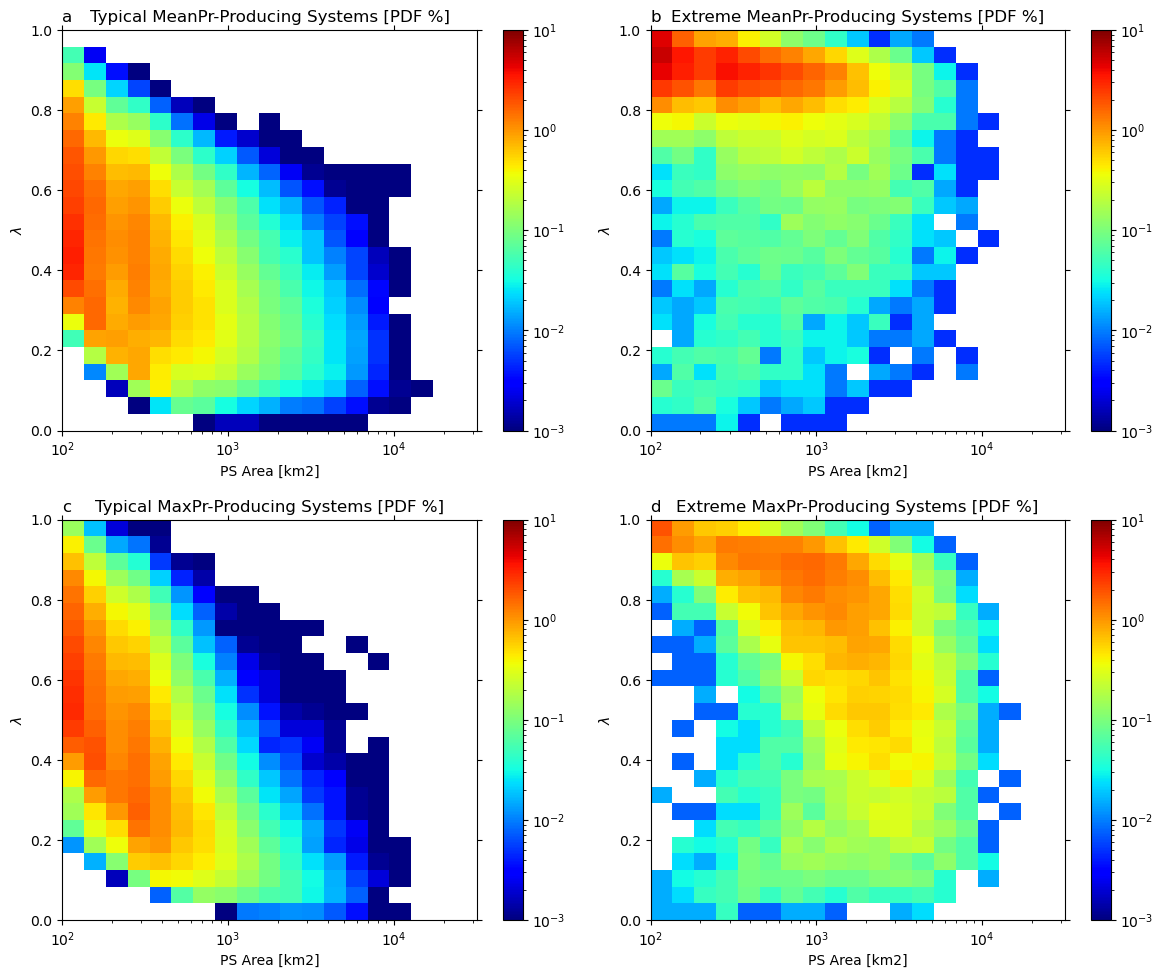

In [12]:
MAXPR_THRESH = 5
MAXPR_EXTREME_THRESH = 80
MEANPR_EXTREME_THRESH = 10
#
# Data is loaded.
#
regions = [
    wmp_region(),
      cio_region(),
        s]
df = pd.concat(
    [load_pf_stats(r) for r in regions], 
    axis=0
)
active_mask = (df['max_precip'] >= MAXPR_THRESH)
df = df[active_mask]

#
# Get data from relevant samples of PSs
#
extreme_max_id = df['max_precip']>=MAXPR_EXTREME_THRESH
extreme_max_df = df[extreme_max_id]
extreme_mean_id = (df['total_precip']/df['num_pixels'])>=MEANPR_EXTREME_THRESH
extreme_mean_df = df[extreme_mean_id]

typical_max_id = (df['max_precip']<=df['max_precip'].quantile(0.75)) & (df['max_precip']>=df['max_precip'].quantile(0.25))
# If looking at the mean non-core precip doesn't change much
# mean = (df['total_precip']-df['largest_10mmhr_cluster_precip_8conn'])/(df['num_pixels']-df['largest_10mmhr_cluster_size_8conn'])
mean = df['total_precip']/df['num_pixels']
typical_mean_id = (mean<=mean.quantile(0.75)) & (mean>=mean.quantile(0.25))
typical_max_df = df[typical_max_id]
typical_mean_df = df[typical_mean_id]

######
#
# Now we plt the distributions of typical and extreme systems
#

def _loc(df):
    return df[f'largest_{MAXPR_THRESH}mmhr_cluster_precip_8conn']/df['total_precip']

def _area(df):
    return df['num_pixels'] * 25

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 10))
area_bins = np.logspace(2, 4.5, 20)
loc_bins = np.linspace(0, 1, 25)
#
# First row is for mean PR
#
ax = axs[0,0]
loc = _loc(typical_mean_df)
area = _area(typical_mean_df)
count = binned_statistic_2d(
    x=loc, 
    y=area, 
    values=None, 
    statistic='count',
    bins=[loc_bins, area_bins]
).statistic

pdf = 100*count / count.sum()

x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)

c = (
    ax.pcolormesh(
        x_mesh, 
        y_mesh, 
        pdf, 
        cmap=plt.cm.plasma, 
        norm=colors.LogNorm(vmin=1e-3, vmax=1e1)
    )   
)
fig.colorbar(c)
ax.set_xscale('log')
ax.set_xlim(area_bins.min(), area_bins.max())
ax.set_xlabel('PS Area [km2]')
ax.set_ylabel(r'$\lambda$')
ax.set_title('a', loc='left')
ax.set_title('Typical MeanPr-Producing Systems [PDF %]')

ax = axs[0,1]
loc = _loc(extreme_mean_df)
area = _area(extreme_mean_df)
count = binned_statistic_2d(
    x=loc, 
    y=area, 
    values=None, 
    statistic='count',
    bins=[loc_bins, area_bins]
).statistic

pdf = 100*count / count.sum()

x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)

c = (
    ax.pcolormesh(
        x_mesh, 
        y_mesh, 
        pdf, 
        cmap=plt.cm.plasma, 
        norm=colors.LogNorm(vmin=1e-3, vmax=1e1)
    )   
)
fig.colorbar(c)
ax.set_xscale('log')
ax.set_xlim(area_bins.min(), area_bins.max())
ax.set_xlabel('PS Area [km2]')
ax.set_ylabel(r'$\lambda$')
ax.set_title('b', loc='left')
ax.set_title('Extreme MeanPr-Producing Systems [PDF %]')


#
# Now the second row for MaxPr
#
ax = axs[1,0]
loc = _loc(typical_max_df)
area = _area(typical_max_df)
count = binned_statistic_2d(
    x=loc, 
    y=area, 
    values=None, 
    statistic='count',
    bins=[loc_bins, area_bins]
).statistic

pdf = 100*count / count.sum()

x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)

c = (
    ax.pcolormesh(
        x_mesh, 
        y_mesh, 
        pdf, 
        cmap=plt.cm.plasma, 
        norm=colors.LogNorm(vmin=1e-3, vmax=1e1)
    )   
)
fig.colorbar(c)
ax.set_xscale('log')
ax.set_xlim(area_bins.min(), area_bins.max())
ax.set_xlabel('PS Area [km2]')
ax.set_ylabel(r'$\lambda$')
ax.set_title('c', loc='left')
ax.set_title('Typical MaxPr-Producing Systems [PDF %]')

ax = axs[1,1]
loc = _loc(extreme_max_df)
area = _area(extreme_max_df)
count = binned_statistic_2d(
    x=loc, 
    y=area, 
    values=None, 
    statistic='count',
    bins=[loc_bins, area_bins]
).statistic

pdf = 100*count / count.sum()

x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)

c = (
    ax.pcolormesh(
        x_mesh, 
        y_mesh, 
        pdf, 
        cmap=plt.cm.plasma, 
        norm=colors.LogNorm(vmin=1e-3, vmax=1e1)
    )   
)
fig.colorbar(c)
ax.set_xscale('log')
ax.set_xlim(area_bins.min(), area_bins.max())
ax.set_xlabel('PS Area [km2]')
ax.set_ylabel(r'$\lambda$')
ax.set_title('d', loc='left')
ax.set_title('Extreme MaxPr-Producing Systems [PDF %]')


######
for ax in axs.ravel():
    ax.tick_params(top=True, right=True, bottom=True, left=True)
fig.tight_layout(pad=1.5)

(100.0, 31622.776601683792)

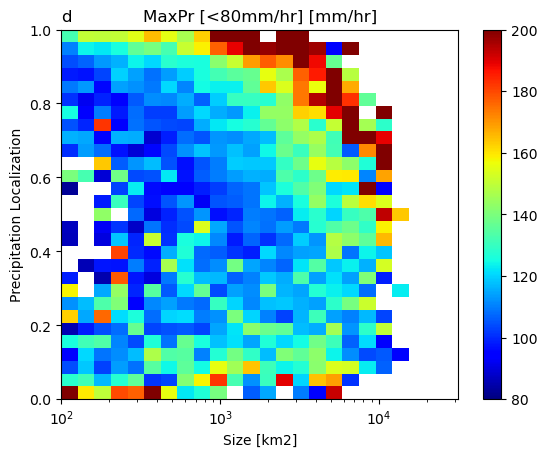

In [34]:
fig, ax = plt.subplots()
MAXPR_THRESH = 5


regions = [
    afc_region(), 
    cio_region(), 
    wmp_region(), 
    epo_region(),
    h01_region(), 
    sam_region(),
    sas_region()
]

df = pd.concat(
    [load_pf_stats(r) for r in regions], 
    axis=0
)

active_mask = (df['max_precip'])> 80
df = df[active_mask]

area = df['num_pixels'] * 25
loc = df[f'largest_{MAXPR_THRESH}mmhr_cluster_precip_4conn']/df['total_precip']
sigma = df[f'largest_{MAXPR_THRESH}mmhr_cluster_size_4conn']/df['num_pixels']
mean_pr = df['total_precip']/df['num_pixels']
max_pr = df['max_precip']

area_bins = np.logspace(2, 4.5, 25)
loc_bins = np.linspace(0, 1, 30)
sigma_bins = np.linspace(0, 1, 30)

mean = binned_statistic_2d(
    x=loc, 
    y=area, 
    values=max_pr, 
    statistic=np.nanmean,
    bins=[loc_bins, area_bins]
).statistic

x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)

c = (
    ax.pcolormesh(
        x_mesh, 
        y_mesh, 
        mean, 
        cmap=plt.cm.plasma, 
        norm=colors.Normalize(vmin=80, vmax=200), 
    )   
)

ax.plot([0,1], [0,1], color='black', lw=4)
fig.colorbar(c)
ax.set_xlabel('Size [km2]')
ax.set_xscale('log')
ax.set_ylabel('Precipitation Localization')
ax.set_title('d', loc='left')
ax.set_title('MaxPr [<80mm/hr] [mm/hr]')
ax.set_xlim(area_bins.min(), area_bins.max())

In [18]:
df['max_precip'].max()

299.9795837402344